# 湖泊水量模拟归因模型 - 使用清理后的数据

本notebook使用预处理后的清洁数据进行TabPFN模型训练和预测。

数据来源：`data/cleaned_data.csv` (已删除空值的数据)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from tabpfn import TabPFNRegressor
import warnings
import shap

# 忽略警告
warnings.filterwarnings("ignore")

# 读取清理后的数据
df = pd.read_csv('data/data.csv')
print(f"数据形状: {df.shape}")
print(f"列名: {list(df.columns)}")
df

数据形状: (287, 27)
列名: ['Date', 'Water_Volumn_Change', 'ET', 'GPP', 'LST_DAY', 'NPP', 'PRECIPITATION', 'Soil_Moisture', 'SRAD', 'Temperature', 'Snow_Cover', 'Wind_Speed', 'Vap', 'NDVI', 'Nighttime', 'CO2', 'Cropland_Area', 'Forest_Area', 'Steppe_Area', 'Non-Vegetated/Artificial Land_Area', 'Wetland_Area', 'Snow/Ice_Area', 'Population_Density', 'Human Influence Index', 'CH4', 'N2O', 'SF6']


d:\miniconda\envs\tab\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Date  Water_Volumn_Change            ET          GPP    LST_DAY  \
0     2000/2/1         1.897152e+09   3367.344686  1254.500000   4.555004   
1     2000/3/1        -2.697790e+09   5557.613652  1254.500000  11.343773   
2     2000/4/1        -7.646191e+09   9434.919388  1254.500000  18.565325   
3     2000/5/1        -1.610497e+09  18073.534650  1254.500000  23.746123   
4     2000/6/1        -1.983864e+08  26779.509260  1254.500000  25.104066   
..         ...                  ...           ...          ...        ...   
282   2023/8/1         1.276395e+10  33462.370990  1257.875692  19.121898   
283   2023/9/1         3.601250e+09  26428.453520  1257.875692  18.403199   
284  2023/10/1        -5.868944e+09  12200.210070  1257.875692   8.548688   
285  2023/11/1        -1.998741e+09   4442.220835  1257.875692   3.552135   
286  2023/12/1        -1.047024e+10   2489.231312  1257.875692  -2.312323   

           NPP  PRECIPITATION  Soil_Moisture        SRAD  Temperature  ...  \
0    21.971000     745.496486      16.311511  154.106456    -2.027500  ...   
1    21.971000     842.390779      16.316516  194.309461    -5.540541  ...   
2    21.971000    2190.938979      17.196637  227.586542    -7.530278  ...   
3    21.971000    4779.225252      20.891857  246.816513    -8.624676  ...   
4    21.971000    7343.000179      19.319299  230.092785    -6.239087  ...   
..         ...            ...            ...         ...          ...  ...   
282  25.867686    2690.610293      13.973825  187.891349    -0.561821  ...   
283  25.867686    7406.156617      10.689256  199.671413     2.351371  ...   
284  25.867686   11562.428040      10.534252  174.063885     3.701637  ...   
285  25.867686   11813.842910      10.524489  143.238778     3.779917  ...   
286  25.867686    6110.425702      10.524412  118.764857     1.896068  ...   

     Forest_Area   Steppe_Area  Non-Vegetated/Artificial Land_Area  \
0    18600019.18  1.370000e+11                         17091324409   
1    18600019.18  1.370000e+11                         17091324409   
2    18600019.18  1.370000e+11                         17091324409   
3    18600019.18  1.370000e+11                         17091324409   
4    18600019.18  1.370000e+11                         17091324409   
..           ...           ...                                 ...   
282  16829197.74  1.420000e+11                         10809838467   
283  16829197.74  1.420000e+11                         10809838467   
284  16829197.74  1.420000e+11                         10809838467   
285  16829197.74  1.420000e+11                         10809838467   
286  16829197.74  1.420000e+11                         10809838467   

     Wetland_Area  Snow/Ice_Area  Population_Density  Human Influence Index  \
0     294292889.0     1777061380        11988.062930             196.871532   
1     294292889.0     1777061380        11988.062930             196.871532   
2     294292889.0     1777061380        11988.062930             196.871532   
3     294292889.0     1777061380        11988.062930             196.871532   
4     294292889.0     1777061380        11988.062930             196.871532   
..            ...            ...                 ...                    ...   
282   237172960.3     1161283969         9734.157106             310.999226   
283   237172960.3     1161283969         9734.157106             310.999226   
284   237172960.3     1161283969         9734.157106             310.999226   
285   237172960.3     1161283969         9734.157106             310.999226   
286   237172960.3     1161283969         9734.157106             310.999226   

         CH4      N2O    SF6  
0    1775.42  316.544   4.51  
1    1776.51  316.380   4.53  
2    1777.22  316.438   4.55  
3    1774.55  316.428   4.57  
4    1768.15  316.436   4.58  
..       ...      ...    ...  
282  1916.87  336.650  11.45  
283  1924.67  336.740  11.47  
284  1930.40  336.890  11.50  
285  1931.64  337.090  11.56  
286  1931.17  337

In [2]:
# 使用已知的最佳种子7
seed = 7

# 定义特征和目标变量
feature_columns = ['ET', 'GPP', 'LST_DAY', 'NPP', 'PRECIPITATION', 'Soil_Moisture', 'SRAD', 'Temperature', \
    'Snow_Cover', 'Wind_Speed', 'Vap', 'NDVI', 'Nighttime', 'CO2', 'Cropland_Area', 'Forest_Area', 'Steppe_Area',\
         'Non-Vegetated/Artificial Land_Area', 'Wetland_Area', 'Snow/Ice_Area', 'Population_Density', 'Human Influence Index', 'CH4', 'N2O', 'SF6']

# 检查所有特征列是否存在
missing_features = [col for col in feature_columns if col not in df.columns]
if missing_features:
    print(f"警告：以下特征列在数据中不存在: {missing_features}")
    # 使用实际存在的特征列
    available_features = [col for col in feature_columns if col in df.columns]
    print(f"使用可用的特征列: {available_features}")
    X = df[available_features]
else:
    X = df[feature_columns]

y = df['Water_Volumn_Change']

print(f"特征矩阵形状: {X.shape}")
print(f"目标变量形状: {y.shape}")
print(f"使用的特征: {list(X.columns)}")

特征矩阵形状: (287, 25)
目标变量形状: (287,)
使用的特征: ['ET', 'GPP', 'LST_DAY', 'NPP', 'PRECIPITATION', 'Soil_Moisture', 'SRAD', 'Temperature', 'Snow_Cover', 'Wind_Speed', 'Vap', 'NDVI', 'Nighttime', 'CO2', 'Cropland_Area', 'Forest_Area', 'Steppe_Area', 'Non-Vegetated/Artificial Land_Area', 'Wetland_Area', 'Snow/Ice_Area', 'Population_Density', 'Human Influence Index', 'CH4', 'N2O', 'SF6']


In [3]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

print(f"训练集特征形状: {X_train.shape}")
print(f"测试集特征形状: {X_test.shape}")
print(f"训练集目标变量形状: {y_train.shape}")
print(f"测试集目标变量形状: {y_test.shape}")

训练集特征形状: (229, 25)
测试集特征形状: (58, 25)
训练集目标变量形状: (229,)
测试集目标变量形状: (58,)


In [4]:
# 初始化并训练模型
print("正在初始化TabPFN模型...")
model = TabPFNRegressor(model_path="model/tabpfn-v2-regressor.ckpt", device="cuda:0")

print("正在训练模型...")
model.fit(X_train, y_train)
print("模型训练完成！")

正在初始化TabPFN模型...
正在训练模型...
模型训练完成！


In [5]:
# 预测
print("正在进行预测...")
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# 计算评估指标
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)

print(f'\n=== 模型评估结果 ===')
print(f'种子: {seed}')
print(f'训练集 R² Score: {train_r2:.4f}')
print(f'测试集 R² Score: {test_r2:.4f}')
print(f'训练集 MSE: {train_mse:.2e}')
print(f'测试集 MSE: {test_mse:.2e}')

# 保存预测结果供后续使用
best_predictions = (y_pred_train, y_pred_test)

正在进行预测...

=== 模型评估结果 ===
种子: 7
训练集 R² Score: 0.5999
测试集 R² Score: 0.5607
训练集 MSE: 7.22e+18
测试集 MSE: 6.87e+18


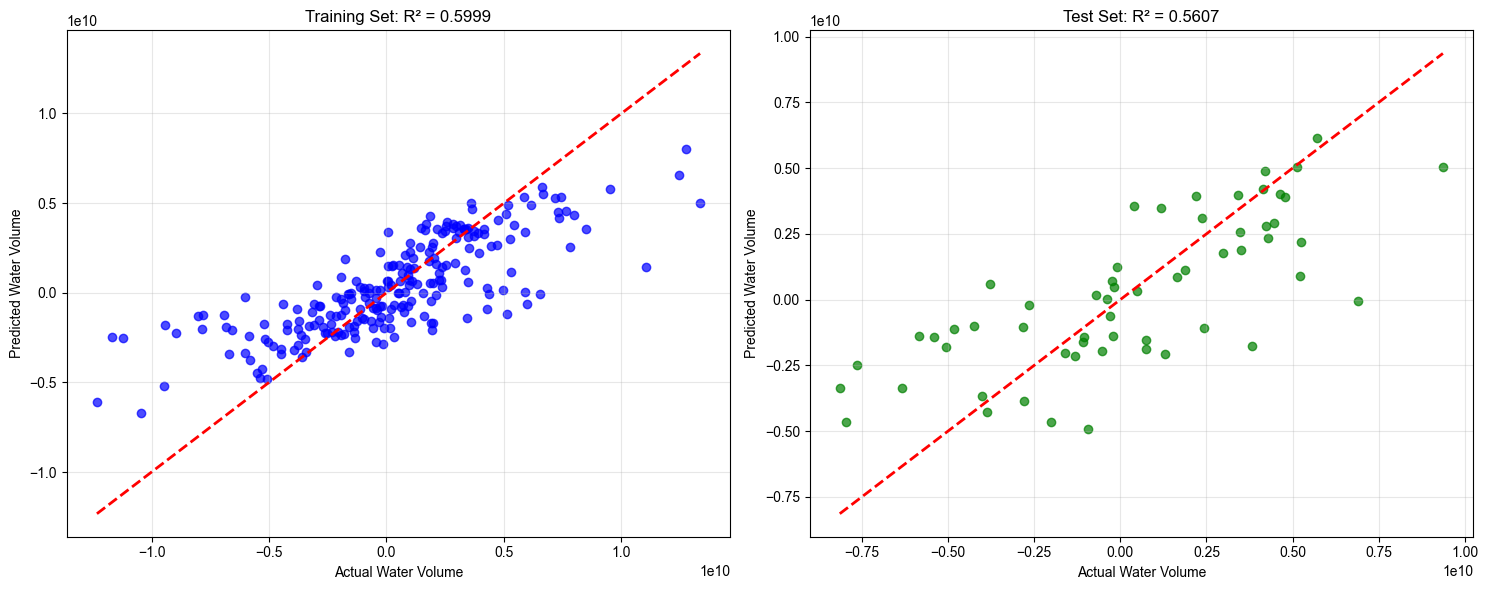

In [6]:
# 可视化预测结果
plt.rcParams['font.family'] = 'Arial'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 训练集预测vs实际
ax1.scatter(y_train, y_pred_train, alpha=0.7, color='blue')
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
ax1.set_xlabel('Actual Water Volume')
ax1.set_ylabel('Predicted Water Volume')
ax1.set_title(f'Training Set: R² = {train_r2:.4f}')
ax1.grid(True, alpha=0.3)

# 测试集预测vs实际
ax2.scatter(y_test, y_pred_test, alpha=0.7, color='green')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax2.set_xlabel('Actual Water Volume')
ax2.set_ylabel('Predicted Water Volume')
ax2.set_title(f'Test Set: R² = {test_r2:.4f}')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

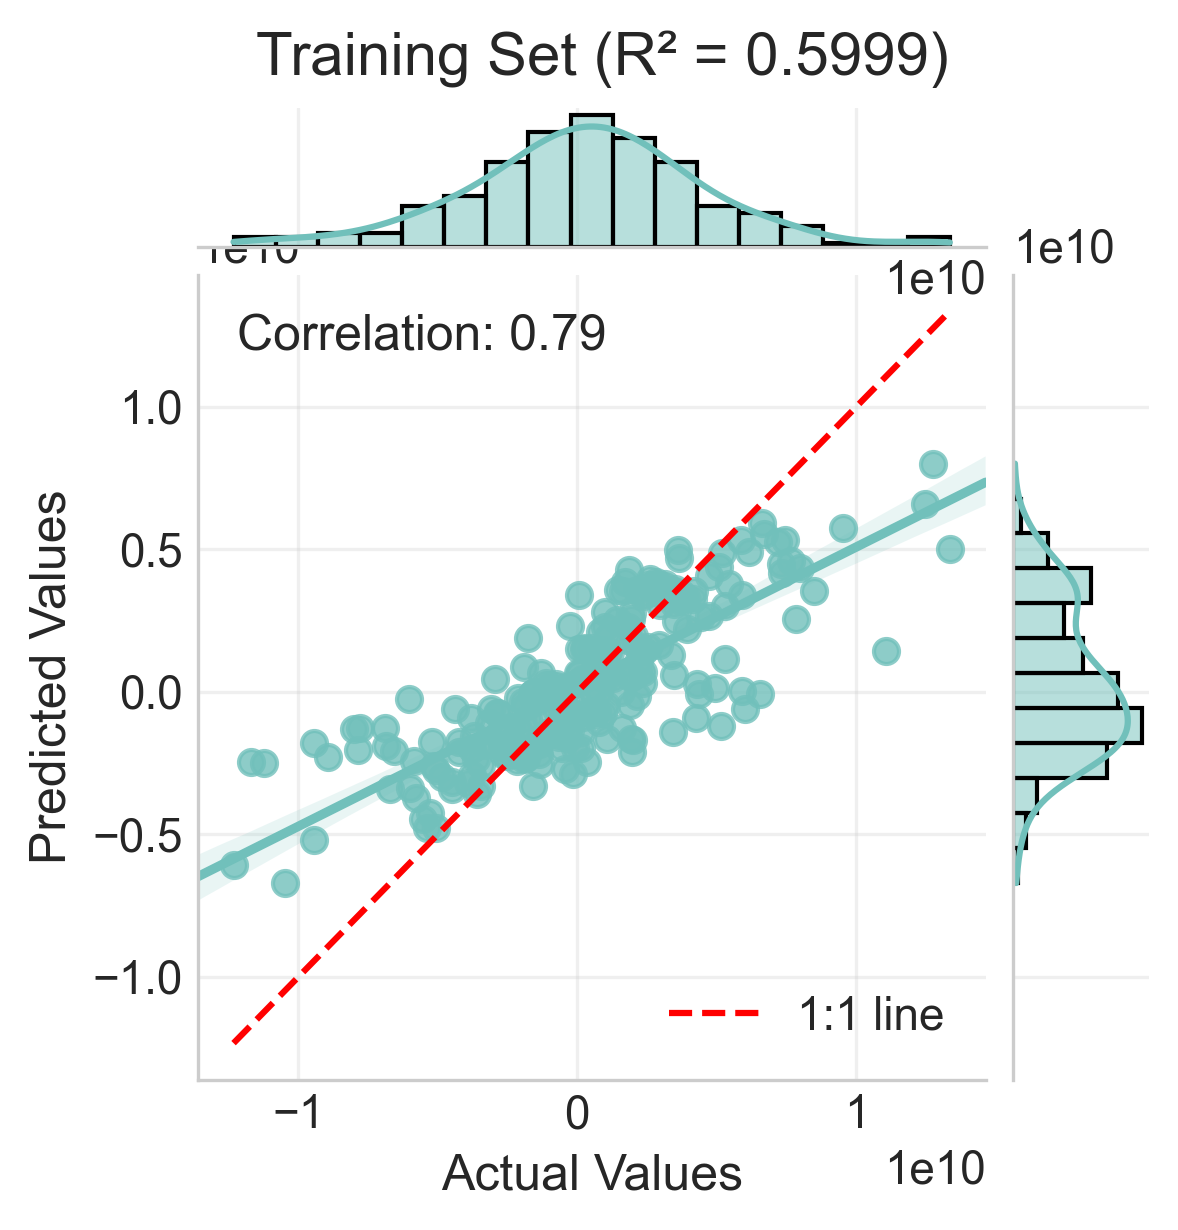

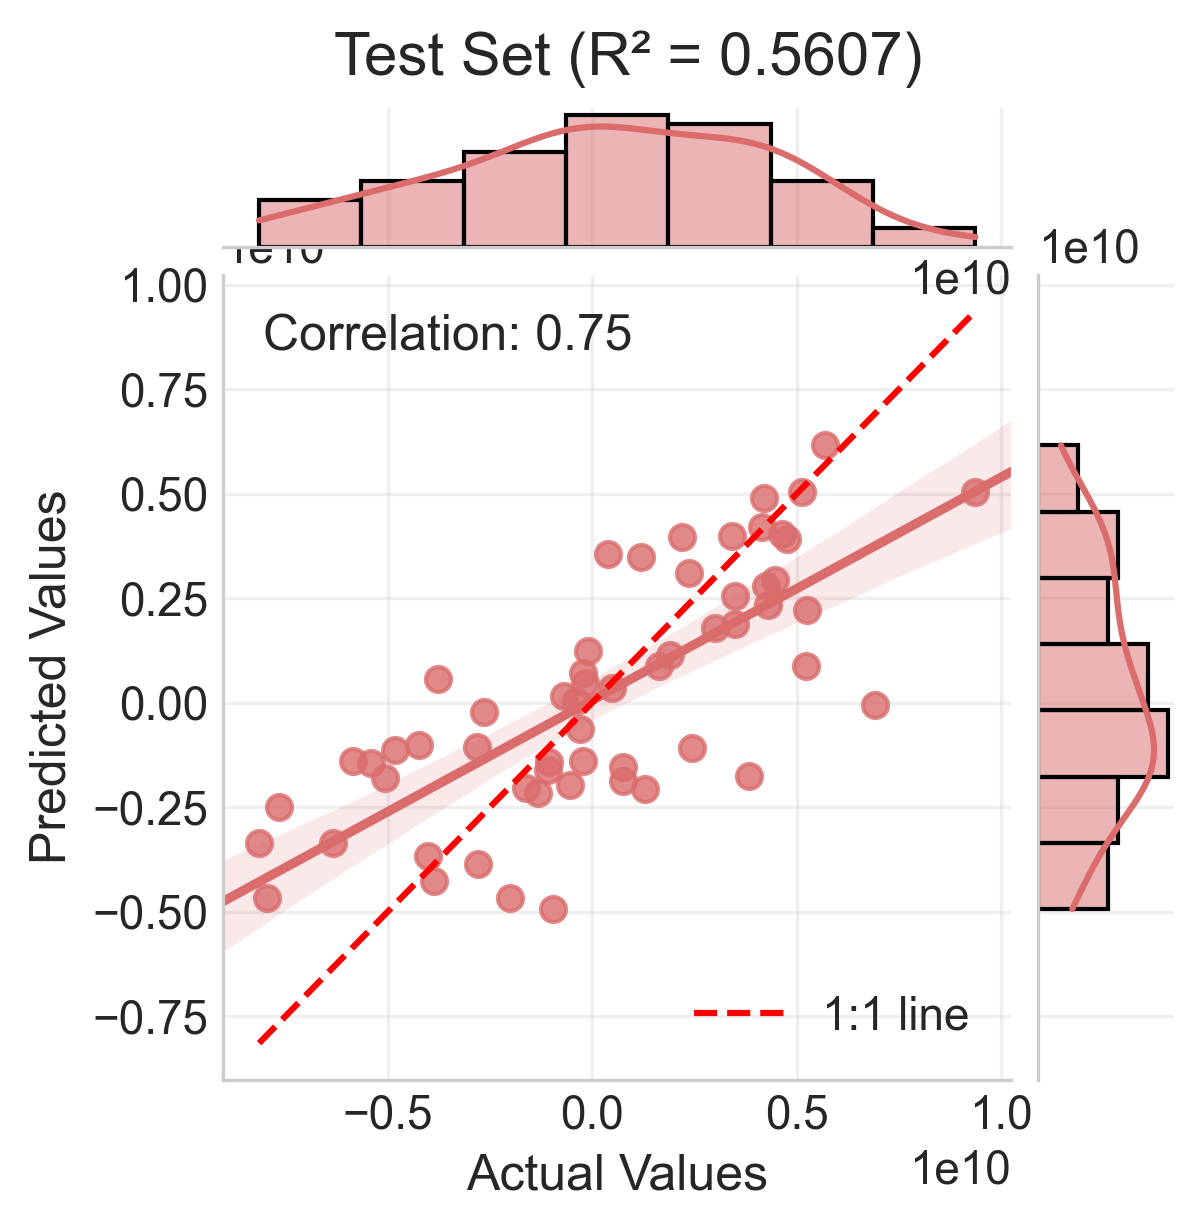


=== Statistics ===
Training Set:
R² Score: 0.5999
Correlation: 0.795

Test Set:
R² Score: 0.5607
Correlation: 0.750


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd



# 设置Nature风格绘图参数
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'figure.dpi': 300,
    'figure.figsize': (2, 2),
    'grid.alpha': 0.3,
    'lines.linewidth': 1.5,
    'axes.linewidth': 0.8,
    'savefig.bbox': 'tight',
    'savefig.transparent': True
})

colors = ['#71C0BB', '#DA6C6C']

# 创建训练集数据框
data_train = pd.DataFrame({
    'Actual': y_train,
    'Predicted': y_pred_train
})

# 创建测试集数据框
data_test = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_test
})

# 训练集散点图
g1 = sns.jointplot(x="Actual", y="Predicted", data=data_train,
                   kind="reg", truncate=False,
                   color=colors[0], height=4)
g1.ax_joint.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', label='1:1 line')
g1.ax_joint.set_xlabel('Actual Values')
g1.ax_joint.set_ylabel('Predicted Values')
g1.fig.suptitle(f'Training Set (R² = {train_r2:.4f})', y=1.02)
g1.ax_joint.legend()

# 计算训练集统计指标
train_corr = np.corrcoef(y_train, y_pred_train)[0,1]
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
g1.ax_joint.text(0.05, 0.95, f'Correlation: {train_corr:.2f}', 
                 transform=g1.ax_joint.transAxes, verticalalignment='top')

plt.show()

# 测试集散点图
g2 = sns.jointplot(x="Actual", y="Predicted", data=data_test,
                   kind="reg", truncate=False,
                   color=colors[1], height=4)
g2.ax_joint.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='1:1 line')
g2.ax_joint.set_xlabel('Actual Values')
g2.ax_joint.set_ylabel('Predicted Values')
g2.fig.suptitle(f'Test Set (R² = {test_r2:.4f})', y=1.02)
g2.ax_joint.legend()

# 计算测试集统计指标
test_corr = np.corrcoef(y_test, y_pred_test)[0,1]
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
g2.ax_joint.text(0.05, 0.95, f'Correlation: {test_corr:.2f}', 
                 transform=g2.ax_joint.transAxes, verticalalignment='top')

plt.show()

# 打印统计结果
print("\n=== Statistics ===")
print("Training Set:")
print(f"R² Score: {train_r2:.4f}")
print(f"Correlation: {train_corr:.3f}")

print("\nTest Set:")
print(f"R² Score: {test_r2:.4f}")
print(f"Correlation: {test_corr:.3f}")


正在计算SHAP值...
(58, 25) (229, 25)


PermutationExplainer explainer: 59it [12:40, 13.12s/it]                        


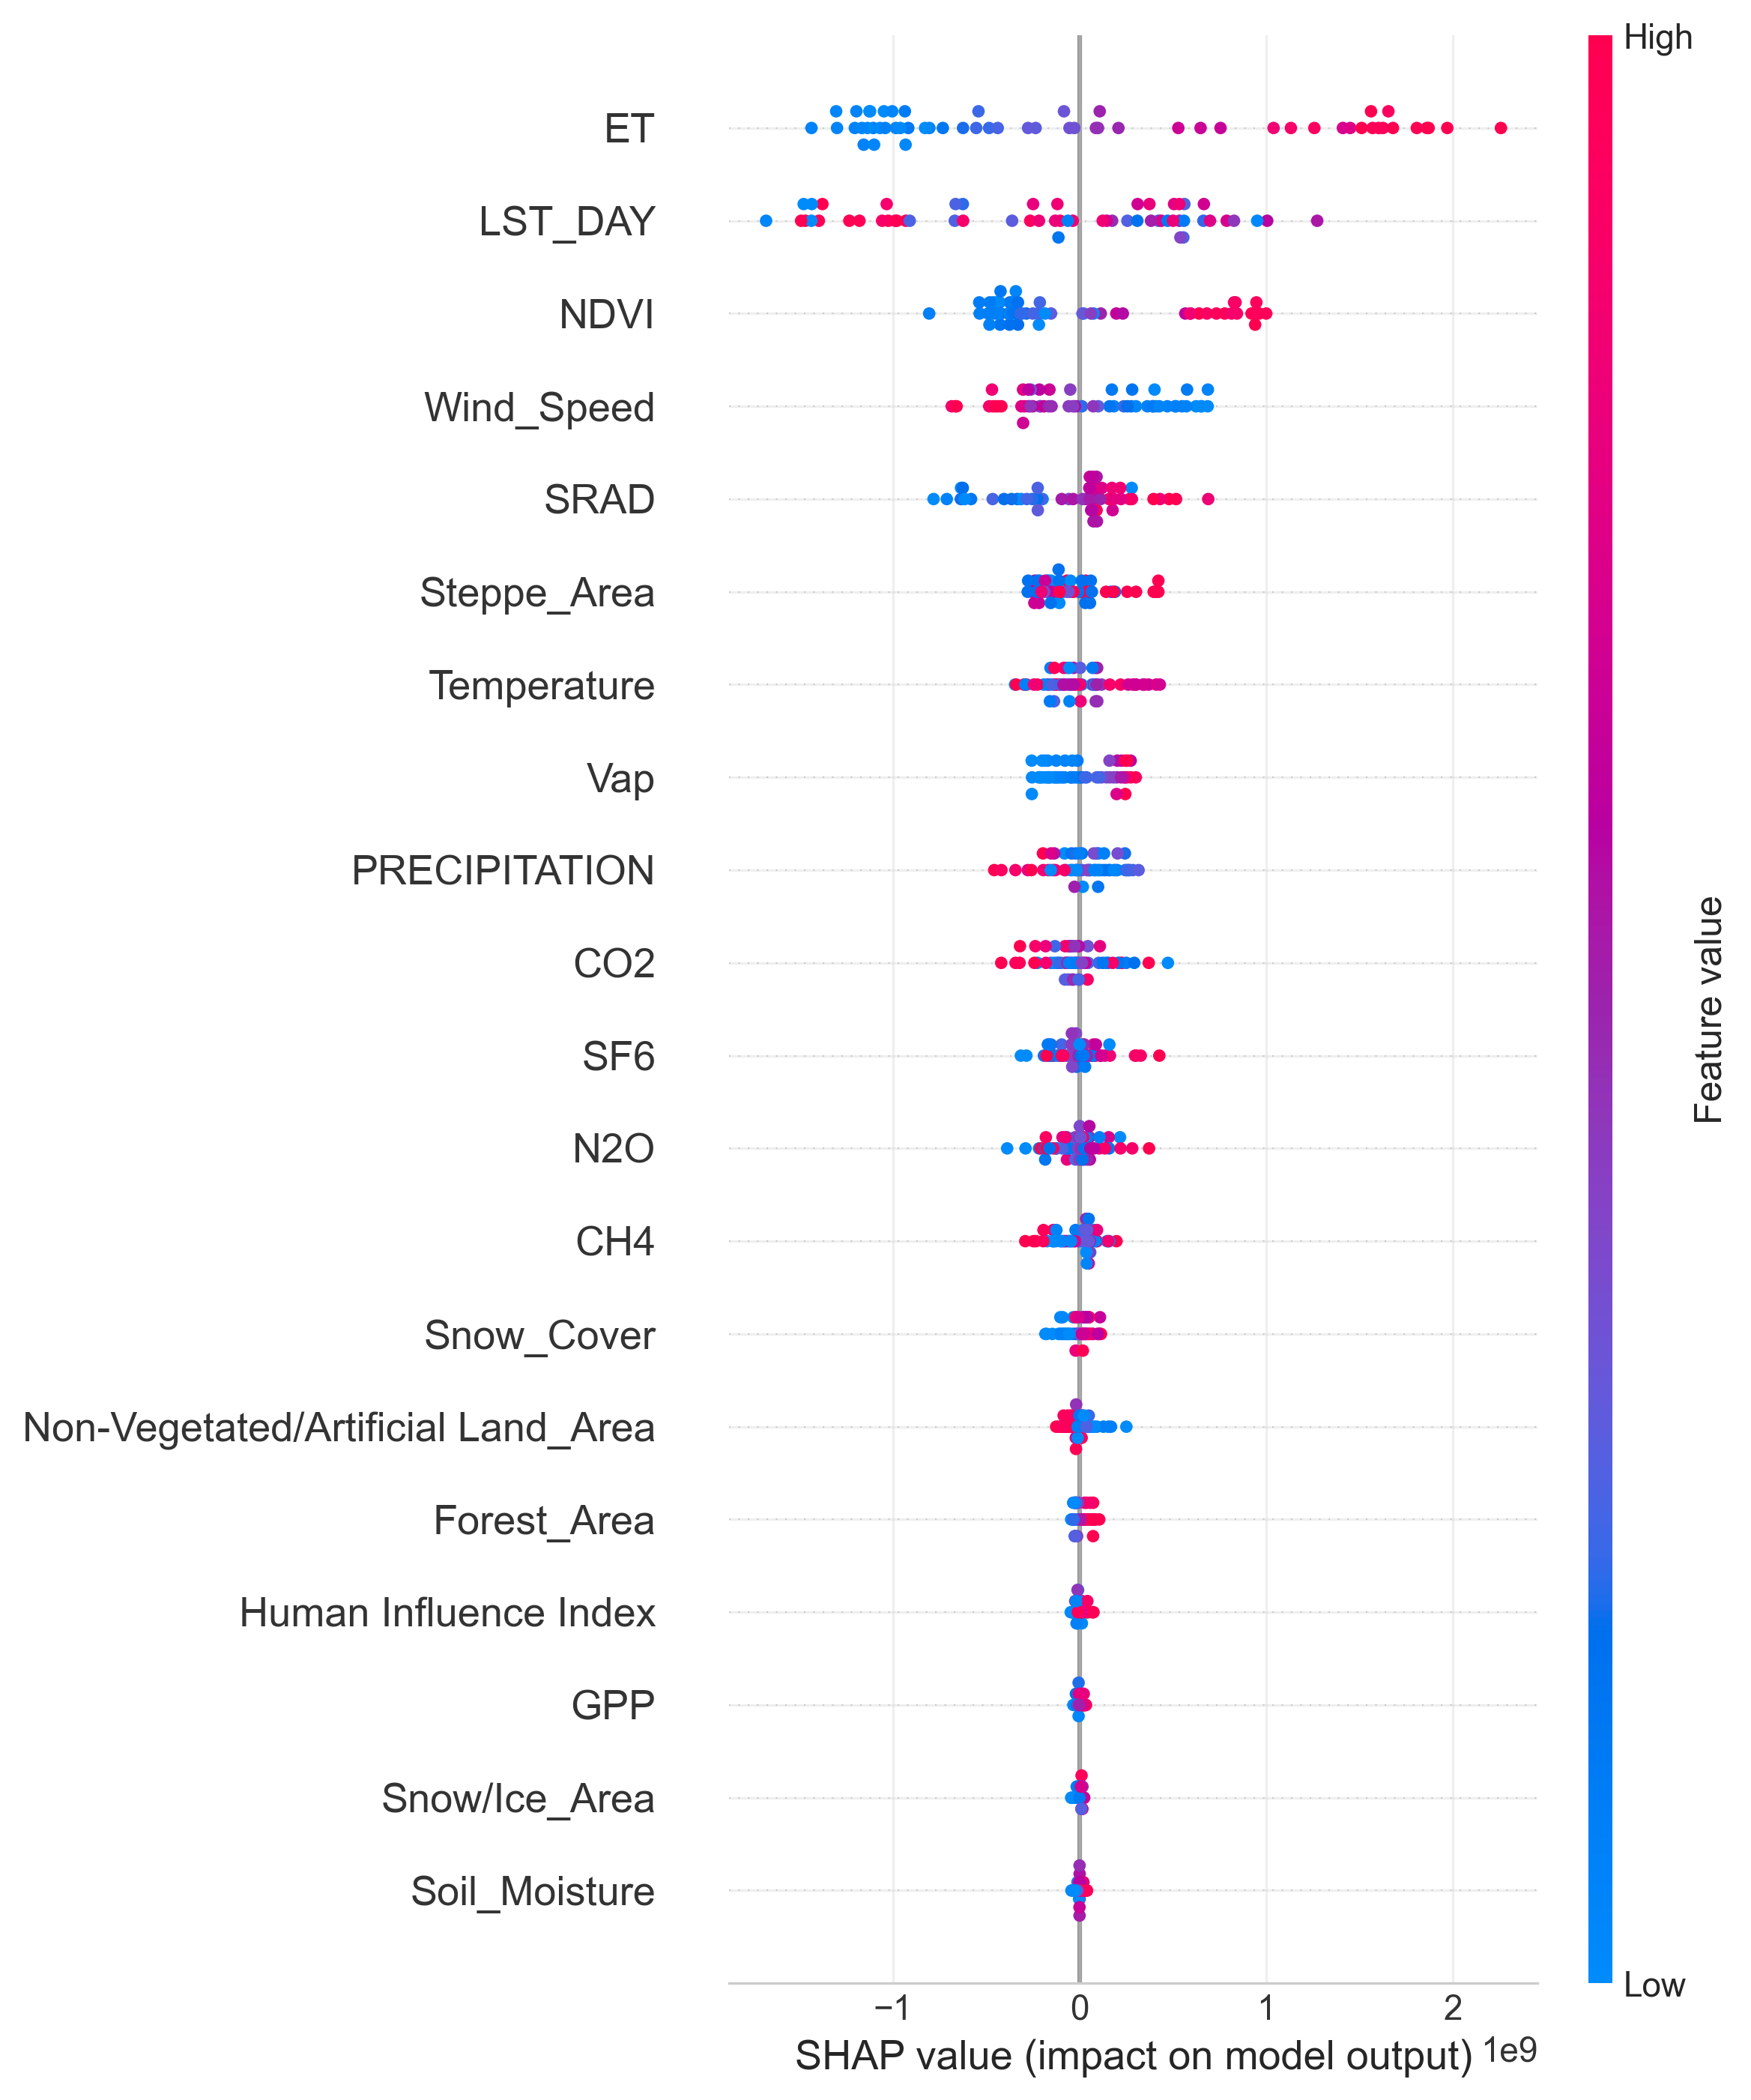

In [8]:
# SHAP分析
print("正在计算SHAP值...")
print(X_test.shape, X_train.shape)

# 创建SHAP解释器
explainer = shap.PermutationExplainer(model.predict, X_train)
shap_values = explainer(X_test)

# 绘制SHAP摘要图
shap.summary_plot(shap_values, X_test)

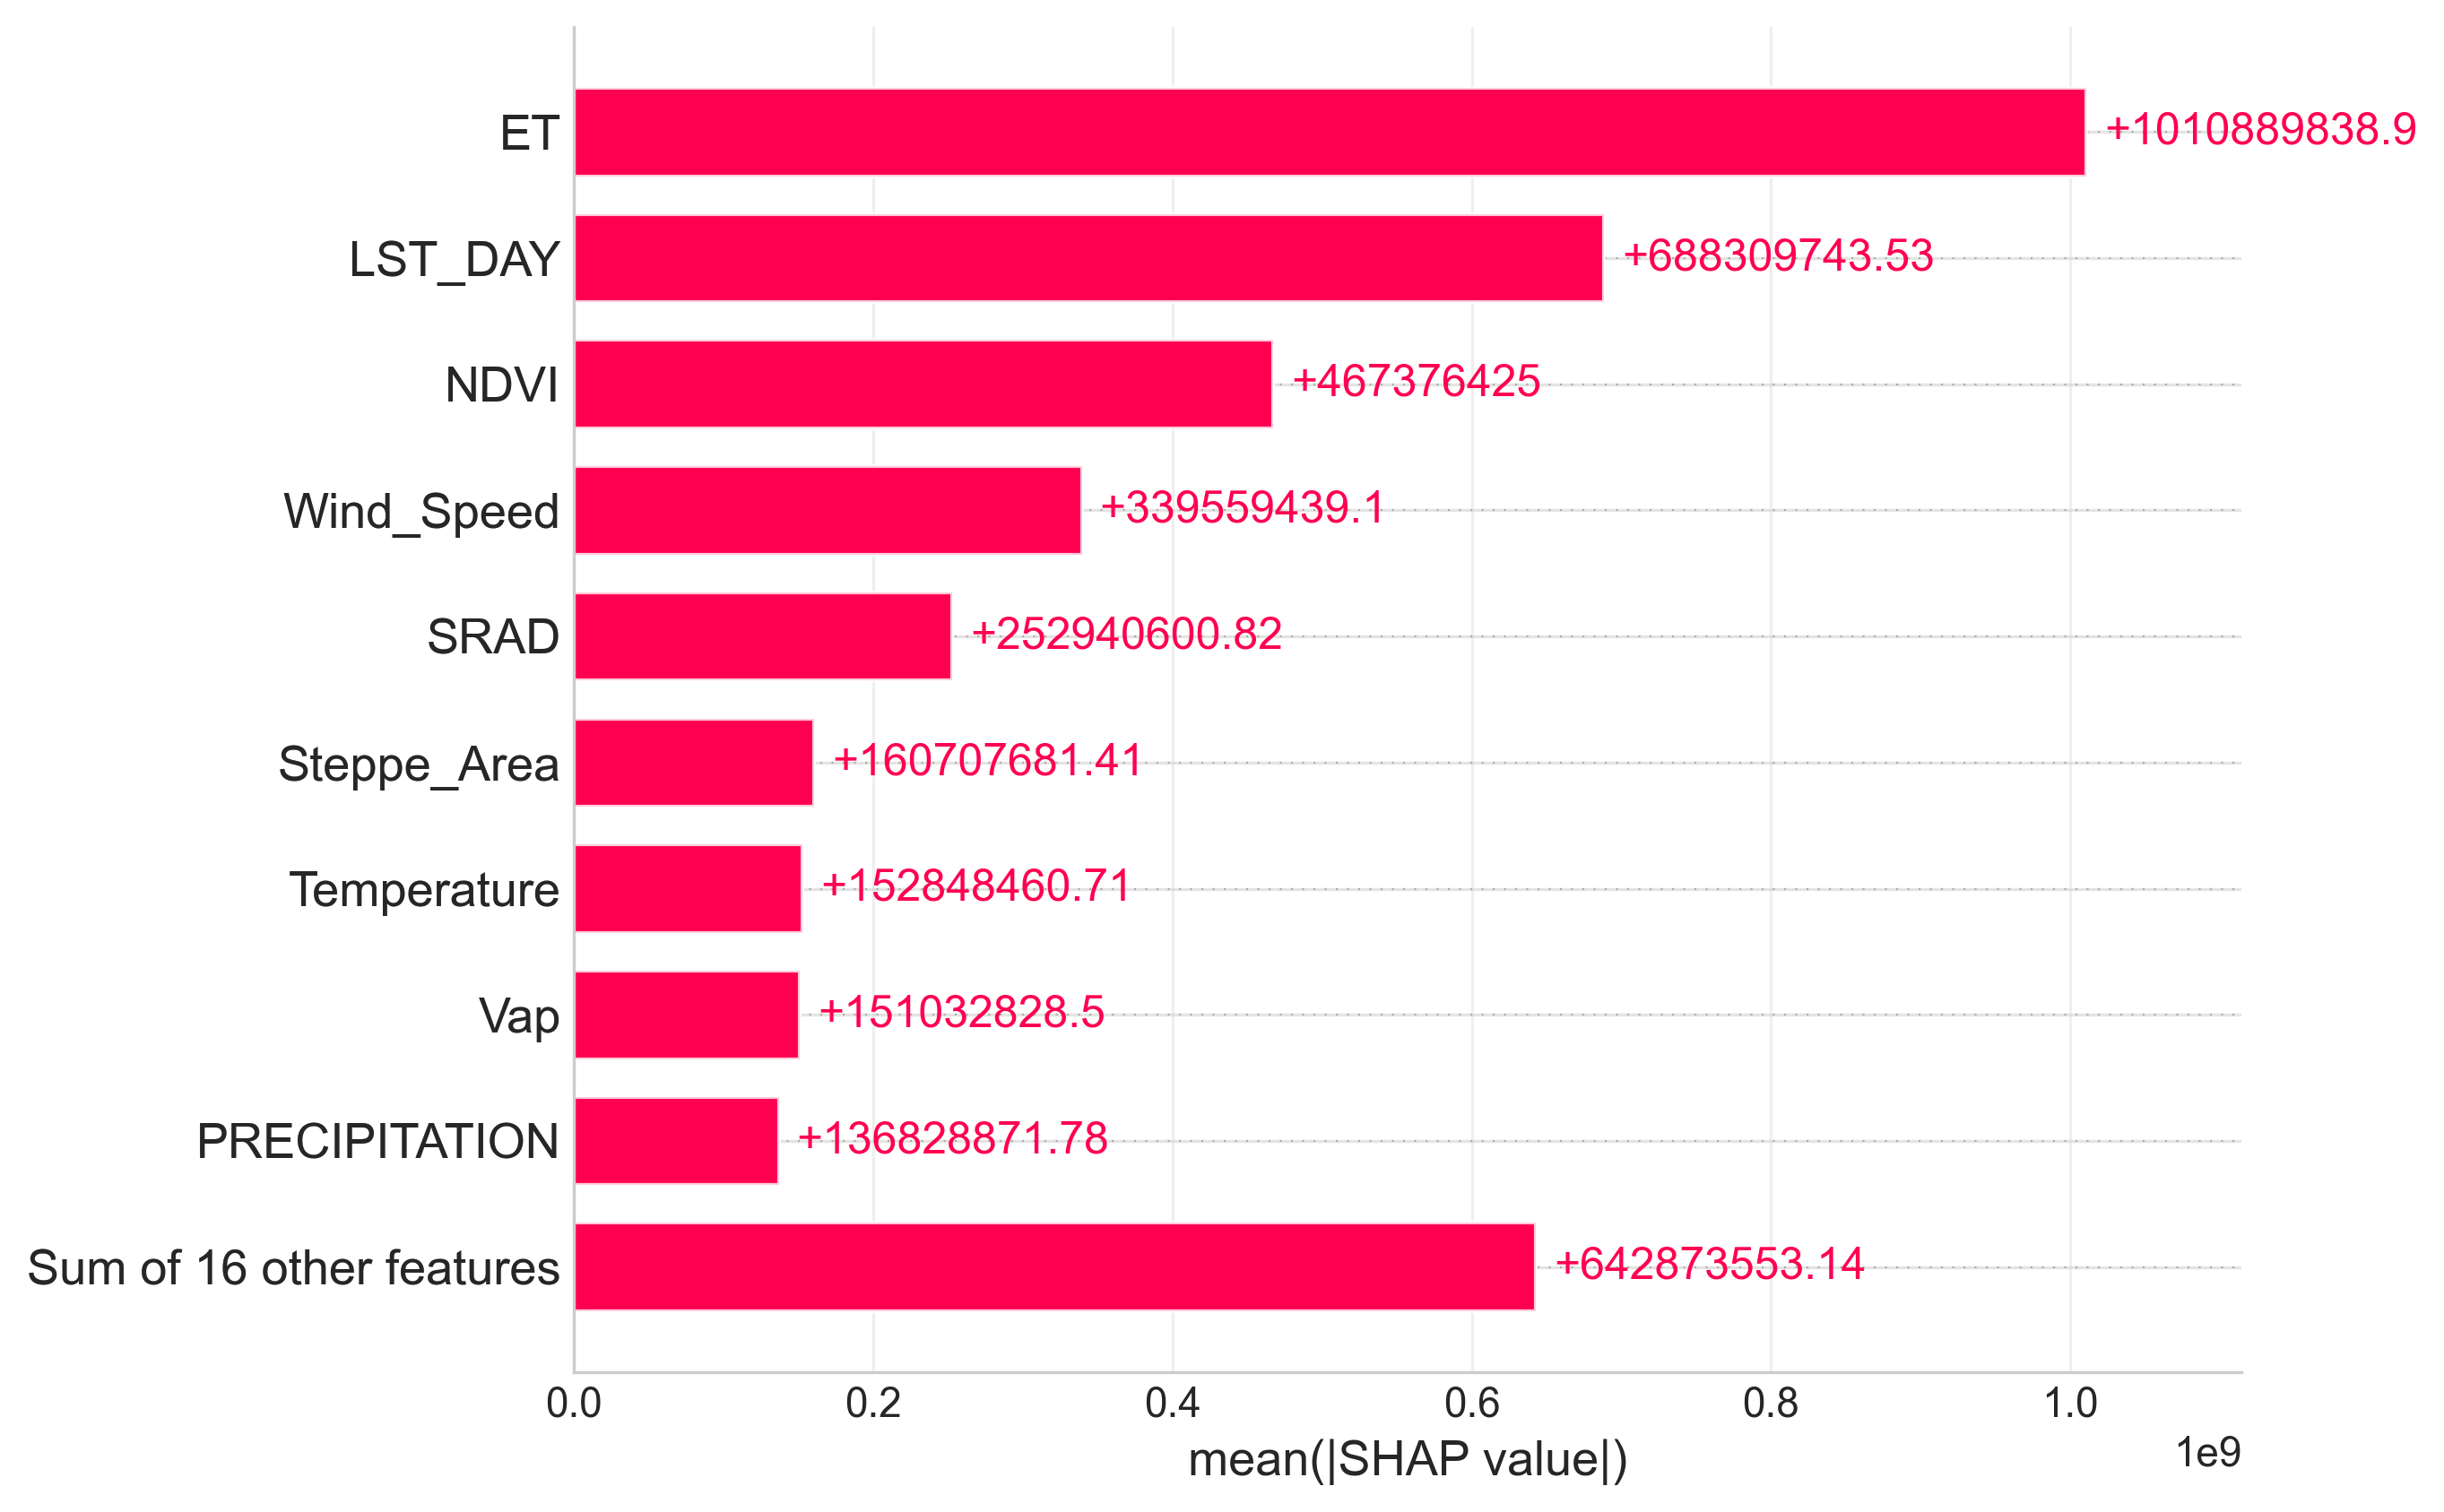

In [9]:
# SHAP条形图
shap.plots.bar(shap_values)

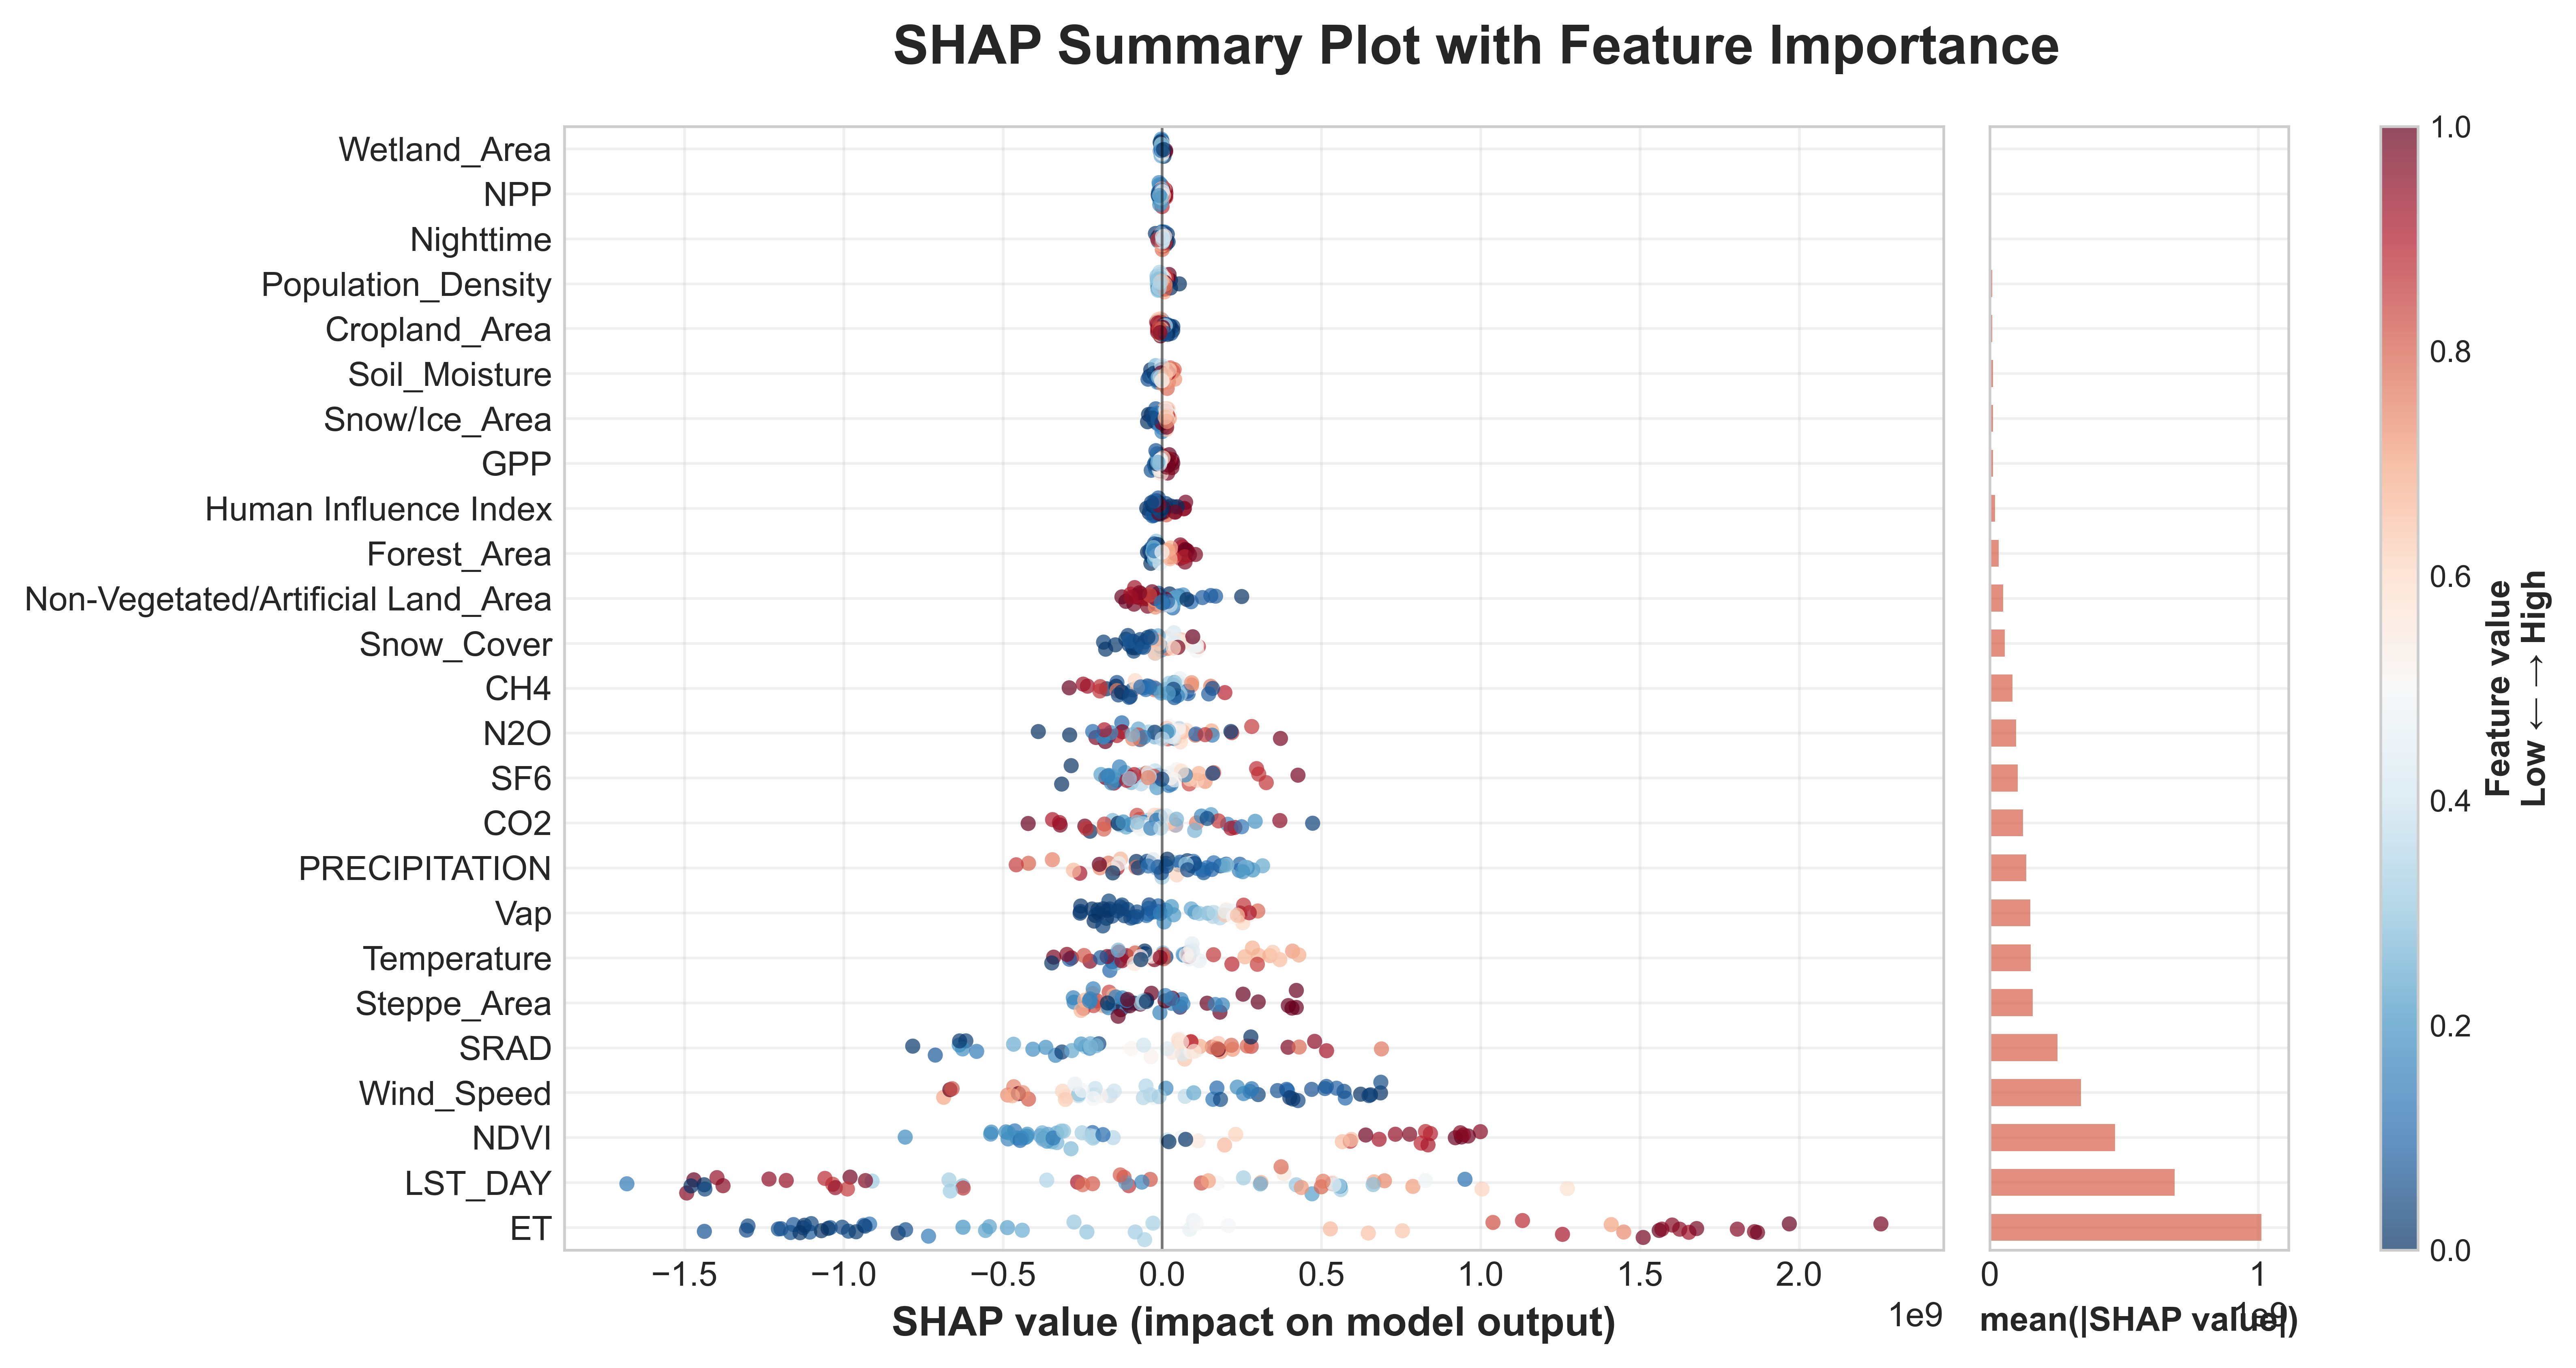

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# 1. 设置Nature风格绘图参数
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 600,
    'grid.alpha': 0.3,
    'lines.linewidth': 1.5,
    'axes.linewidth': 0.8,
    'savefig.bbox': 'tight',
    'savefig.transparent': True
})

def custom_shap_summary_plot(shap_values, X_test, feature_names=None, max_display=25):
    """
    自定义SHAP摘要图，结合蜂群图和重要性柱状图
    
    Parameters:
    -----------
    shap_values : array-like, shape (n_samples, n_features)
        SHAP值
    X_test : DataFrame or array-like, shape (n_samples, n_features)  
        测试数据
    feature_names : list, optional
        特征名称列表
    max_display : int, default=13
        显示的最大特征数量
    """
    
    # 确保输入是numpy数组
    if hasattr(shap_values, 'values'):
        shap_vals = shap_values.values
        feature_vals = shap_values.data
    else:
        shap_vals = np.array(shap_values)
        feature_vals = np.array(X_test)
    
    # 获取特征名称
    if feature_names is None:
        if hasattr(X_test, 'columns'):
            feature_names = X_test.columns.tolist()
        else:
            feature_names = [f'Feature {i}' for i in range(shap_vals.shape[1])]
    
    # 计算特征重要性（平均绝对SHAP值）
    importance = np.mean(np.abs(shap_vals), axis=0)
    
    # 按重要性排序并选择top特征（从大到小）
    sorted_indices = np.argsort(importance)[:max_display][::-1]  # 修改这里，先取前max_display个，再反转
    sorted_importance = importance[sorted_indices]
    sorted_feature_names = [feature_names[i] for i in sorted_indices]
    
    # 创建图形
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), 
                                   gridspec_kw={'width_ratios': [3, 1], 'wspace': 0.05})
    
    # 设置RdBu色彩映射
    colors = ['#053061', '#2166ac', '#4393c3', '#92c5de', '#d1e5f0', 
              '#f7f7f7', '#fddbc7', '#f4a582', '#d6604d', '#b2182b', '#67001f']
    n_bins = 256
    rdbu_cmap = LinearSegmentedColormap.from_list('RdBu', colors, N=n_bins)
    
    # 主图：蜂群图
    y_positions = np.arange(len(sorted_indices))
    
    for i, feature_idx in enumerate(sorted_indices):
        shap_feature = shap_vals[:, feature_idx]
        feature_feature = feature_vals[:, feature_idx]
        
        # 标准化特征值用于颜色映射
        if np.std(feature_feature) > 0:
            norm_feature = (feature_feature - np.min(feature_feature)) / (np.max(feature_feature) - np.min(feature_feature))
        else:
            norm_feature = np.ones_like(feature_feature) * 0.5
        
        # 为每个点添加随机抖动以避免重叠
        y_jitter = y_positions[i] + np.random.normal(0, 0.1, len(shap_feature))
        
        # 绘制散点
        scatter = ax1.scatter(shap_feature, y_jitter, 
                            c=norm_feature, cmap=rdbu_cmap, 
                            alpha=0.7, s=20, edgecolors='none')
    
    # 设置主图坐标轴
    ax1.set_yticks(y_positions)
    ax1.set_yticklabels(sorted_feature_names)
    ax1.set_xlabel('SHAP value (impact on model output)', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='x')
    ax1.axvline(x=0, color='black', linestyle='-', alpha=0.5, linewidth=0.8)
    
    # 调整y轴范围
    ax1.set_ylim(-0.5, len(sorted_indices) - 0.5)
    
    # 右侧重要性柱状图
    bars = ax2.barh(y_positions, sorted_importance, 
                    color=rdbu_cmap(0.8), alpha=0.7, height=0.6)
    
    # 设置右侧图坐标轴 - 确保与左图y轴对齐
    ax2.set_yticks(y_positions)
    ax2.set_yticklabels([])  # 不显示标签，但保持刻度位置
    ax2.set_ylim(-0.5, len(sorted_indices) - 0.5)  # 与左图相同的y轴范围
    ax2.set_xlabel('mean(|SHAP value|)', fontsize=10, fontweight='bold')
    ax2.set_xlim(0, max(sorted_importance) * 1.1)  # 稍微减少右边距
    ax2.grid(True, alpha=0.3, axis='x')
    
    # 添加颜色条
    cbar = plt.colorbar(scatter, ax=ax2, pad=0.2, aspect=30)
    cbar.set_label('Feature value\nLow ← → High', fontsize=10, fontweight='bold')
    cbar.ax.tick_params(labelsize=9)
    
    # 设置整体标题
    fig.suptitle('SHAP Summary Plot with Feature Importance', fontsize=16, fontweight='bold', y=0.95)
    
    plt.tight_layout()
    return fig

# 使用示例（假设你已经有了shap_values和X_test）
def create_sample_data():
    """创建示例数据用于演示"""
    np.random.seed(42)
    n_samples, n_features = 200, 13
    
    # 模拟特征名称
    feature_names = ['van der Waals radius', 'Size ratio', 'Contact angle', 
                    'Neutral logD', 'Charge product', 'Zeta potential',
                    'Feature 7', 'Feature 8', 'Feature 9', 'Feature 10',
                    'Feature 11', 'Feature 12', 'Feature 13']
    
    # 模拟SHAP值
    shap_values = np.random.normal(0, 5, (n_samples, n_features))
    # 让某些特征更重要
    shap_values[:, 0] *= 2  # van der Waals radius
    shap_values[:, 1] *= 1.5  # Size ratio
    
    # 模拟特征值
    X_test = pd.DataFrame(np.random.rand(n_samples, n_features), columns=feature_names)
    
    return shap_values, X_test, feature_names


# 如果你要使用实际的SHAP数据，可以这样调用：
fig = custom_shap_summary_plot(shap_values, X_test)
plt.show()

In [11]:
import numpy as np
import pickle
from sklearn.inspection import partial_dependence
from scipy.interpolate import interp1d

# 全局参数 
N_BOOTSTRAP = 10  # Bootstrap迭代次数
N_SAMPLE_SIZE = 30  # 每次Bootstrap的样本大小

# 然后是完整的 compute_partial_dependence 函数...
def compute_partial_dependence(model, X, n_points=50):
    """
    计算部分依赖结果 - 修复版本
    
    主要修复：
    1. 先计算基准网格，确保所有Bootstrap使用相同的特征值网格
    2. 使用插值处理长度不匹配的问题
    3. 严格的数组形状验证
    4. 详细的调试信息
    """
    print("开始计算部分依赖（修复版本）...")
    
    # 获取特征名称
    if hasattr(X, 'columns'):
        feature_names = X.columns.tolist()
    else:
        feature_names = [f'Feature {i}' for i in range(X.shape[1])]
    
    results = {}
    
    for i, feature_name in enumerate(feature_names):
        feature_idx = i
        print(f"\n正在计算特征 {feature_name} (索引 {feature_idx}) 的部分依赖...")
        
        try:
            # 第一步：计算基准网格
            print("  步骤1: 计算基准网格...")
            pd_base = partial_dependence(
                model, X, features=[feature_idx], 
                grid_resolution=n_points, kind='average'
            )
            base_feature_values = pd_base['grid_values'][0]
            base_curve = pd_base['average'][0]
            expected_length = len(base_feature_values)
            print(f"  基准网格长度: {expected_length}")
            
            # 第二步：Bootstrap采样
            print("  步骤2: Bootstrap采样...")
            individual_curves = []
            valid_curves = 0
            
            np.random.seed(42)
            for j in range(N_BOOTSTRAP):
                try:
                    # 使用较小的样本以避免内存问题和提高稳定性
                    sample_size = min(len(X), N_SAMPLE_SIZE)
                    sample_indices = np.random.choice(len(X), size=sample_size, replace=True)
                    
                    if hasattr(X, 'iloc'):
                        X_sample = X.iloc[sample_indices]
                    else:
                        X_sample = X[sample_indices]
                    
                    # 计算部分依赖
                    pd_sample = partial_dependence(
                        model, X_sample, features=[feature_idx], 
                        grid_resolution=n_points, kind='average'
                    )
                    
                    sample_curve = pd_sample['average'][0]
                    sample_values = pd_sample['grid_values'][0]
                    
                    # 检查长度一致性
                    if len(sample_curve) == expected_length:
                        individual_curves.append(sample_curve.copy())
                        valid_curves += 1
                        print(f"    Bootstrap {j}: 成功 (长度={len(sample_curve)})")
                    else:
                        print(f"    Bootstrap {j}: 长度不匹配 ({len(sample_curve)} vs {expected_length})")
                        # 使用插值修正
                        if len(sample_curve) > 1 and len(sample_values) > 1:
                            f = interp1d(sample_values, sample_curve, 
                                       kind='linear', fill_value='extrapolate')
                            corrected_curve = f(base_feature_values)
                            individual_curves.append(corrected_curve)
                            valid_curves += 1
                            print(f"    Bootstrap {j}: 插值修正成功")
                        else:
                            print(f"    Bootstrap {j}: 跳过（数据不足）")
                    
                except Exception as bootstrap_error:
                    print(f"    Bootstrap {j}: 失败 - {bootstrap_error}")
                    # 添加基于基准曲线的噪声版本
                    if len(individual_curves) > 0:
                        base_for_noise = individual_curves[-1]
                    else:
                        base_for_noise = base_curve
                    
                    noise_std = max(np.std(base_for_noise) * 0.1, 0.01)
                    noise = np.random.normal(0, noise_std, expected_length)
                    noisy_curve = base_for_noise + noise
                    individual_curves.append(noisy_curve)
                    valid_curves += 1
                    print(f"    Bootstrap {j}: 使用噪声版本")
            
            print(f"  有效曲线数量: {valid_curves}/{N_BOOTSTRAP}")
            
            # 第三步：确保数组一致性
            print("  步骤3: 处理数组一致性...")
            if len(individual_curves) == 0:
                raise ValueError("没有有效的Bootstrap曲线")
            
            # 验证所有曲线长度
            processed_curves = []
            for idx, curve in enumerate(individual_curves):
                curve_array = np.asarray(curve, dtype=float)
                if curve_array.shape == (expected_length,):
                    processed_curves.append(curve_array)
                else:
                    print(f"    警告: 曲线 {idx} 形状异常: {curve_array.shape}")
            
            if len(processed_curves) == 0:
                raise ValueError("所有曲线都有形状问题")
            
            # 转换为numpy数组
            individual_curves_array = np.array(processed_curves)
            print(f"  最终数组形状: {individual_curves_array.shape}")
            
            # 第四步：计算统计量
            print("  步骤4: 计算统计量...")
            main_curve = np.mean(individual_curves_array, axis=0)
            
            percentiles = {
                '5': np.percentile(individual_curves_array, 5, axis=0),
                '25': np.percentile(individual_curves_array, 25, axis=0),
                '75': np.percentile(individual_curves_array, 75, axis=0),
                '95': np.percentile(individual_curves_array, 95, axis=0)
            }
            
            # 保存结果
            results[feature_name] = {
                'feature_values': base_feature_values,
                'individual_curves': individual_curves_array,
                'main_curve': main_curve,
                'percentiles': percentiles
            }
            
            print(f"  ✓ 特征 {feature_name} 计算完成 - {len(individual_curves_array)}条曲线")
            
        except Exception as e:
            print(f"✗ 特征 {feature_name} 计算失败: {e}")
            print(f"  使用模拟数据进行演示...")
            
            # 创建模拟数据
            if hasattr(X, 'iloc'):
                feature_data = X.iloc[:, feature_idx]
            else:
                feature_data = X[:, feature_idx]
            
            feature_min, feature_max = np.percentile(feature_data, [5, 95])
            feature_values = np.linspace(feature_min, feature_max, n_points)
            
            # 生成模拟的Bootstrap曲线
            np.random.seed(42 + i)
            individual_curves = []
            
            for j in range(N_BOOTSTRAP):
                # 基础趋势 + 个体变异
                base_trend = 37.5 + 3 * np.sin(2 * np.pi * (feature_values - feature_min) / (feature_max - feature_min))
                noise = np.random.normal(0, 1.5, n_points)
                trend_variation = np.random.normal(0, 0.8) * np.linspace(-1, 1, n_points)
                individual_curve = base_trend + noise + trend_variation
                individual_curves.append(individual_curve)
            
            # 计算主曲线和置信区间
            individual_curves = np.array(individual_curves)
            main_curve = np.mean(individual_curves, axis=0)
            
            percentiles = {
                '5': np.percentile(individual_curves, 5, axis=0),
                '25': np.percentile(individual_curves, 25, axis=0),
                '75': np.percentile(individual_curves, 75, axis=0),
                '95': np.percentile(individual_curves, 95, axis=0)
            }
            
            # 保存结果
            results[feature_name] = {
                'feature_values': feature_values,
                'individual_curves': individual_curves,
                'main_curve': main_curve,
                'percentiles': percentiles
            }
            
            print(f"  ✓ 特征 {feature_name} 模拟数据完成")
    
    return results

def save_results(results, filename='pd_results.pkl'):
    """
    保存部分依赖结果到文件
    """
    with open(filename, 'wb') as f:
        pickle.dump(results, f)
    print(f"结果已保存到 {filename}")

# 主执行代码 - 在notebook中使用
if __name__ == "__main__":
    print("=" * 60)
    print("部分依赖计算 - 修复版本")
    print("=" * 60)
    
    # 设置随机种子
    np.random.seed(42)
    
    # 使用测试集样本（确保 model 和 X_test 已经定义）
    try:
        X_sample = X_test
        
        # 计算部分依赖
        results = compute_partial_dependence(model, X_sample)
        
        # 保存结果
        save_results(results)
        
        print("\n" + "=" * 60)
        print("计算完成！结果总结:")
        print("=" * 60)
        
        for feature_name, result in results.items():
            curves_shape = result['individual_curves'].shape
            print(f"{feature_name}: {curves_shape[0]}条曲线, 每条{curves_shape[1]}个点")
        
        print(f"\n✓ 部分依赖计算成功完成！")
        
    except NameError as e:
        print(f"错误: {e}")
        print("请确保在运行此代码之前已经定义了 'model' 和 'X_test' 变量")
        print("建议在Jupyter notebook中运行，并确保之前的训练代码已经执行")
    except Exception as e:
        print(f"计算过程中出现错误: {e}")
        import traceback
        traceback.print_exc()

# 然后执行：
np.random.seed(42)
X_sample = X_test
results = compute_partial_dependence(model, X_sample)
save_results(results)

部分依赖计算 - 修复版本
开始计算部分依赖（修复版本）...

正在计算特征 ET (索引 0) 的部分依赖...
  步骤1: 计算基准网格...
  基准网格长度: 50
  步骤2: Bootstrap采样...
    Bootstrap 0: 长度不匹配 (23 vs 50)
    Bootstrap 0: 插值修正成功
    Bootstrap 1: 长度不匹配 (25 vs 50)
    Bootstrap 1: 插值修正成功
    Bootstrap 2: 长度不匹配 (23 vs 50)
    Bootstrap 2: 插值修正成功
    Bootstrap 3: 长度不匹配 (23 vs 50)
    Bootstrap 3: 插值修正成功
    Bootstrap 4: 长度不匹配 (24 vs 50)
    Bootstrap 4: 插值修正成功
    Bootstrap 5: 长度不匹配 (21 vs 50)
    Bootstrap 5: 插值修正成功
    Bootstrap 6: 长度不匹配 (25 vs 50)
    Bootstrap 6: 插值修正成功
    Bootstrap 7: 长度不匹配 (21 vs 50)
    Bootstrap 7: 插值修正成功
    Bootstrap 8: 长度不匹配 (22 vs 50)
    Bootstrap 8: 插值修正成功
    Bootstrap 9: 长度不匹配 (24 vs 50)
    Bootstrap 9: 插值修正成功
  有效曲线数量: 10/10
  步骤3: 处理数组一致性...
  最终数组形状: (10, 50)
  步骤4: 计算统计量...
  ✓ 特征 ET 计算完成 - 10条曲线

正在计算特征 GPP (索引 1) 的部分依赖...
  步骤1: 计算基准网格...
  基准网格长度: 23
  步骤2: Bootstrap采样...
    Bootstrap 0: 长度不匹配 (15 vs 23)
    Bootstrap 0: 插值修正成功
    Bootstrap 1: 长度不匹配 (17 vs 23)
    Bootstrap 1: 插值修正成功
    Bootstrap 2: 长度不匹

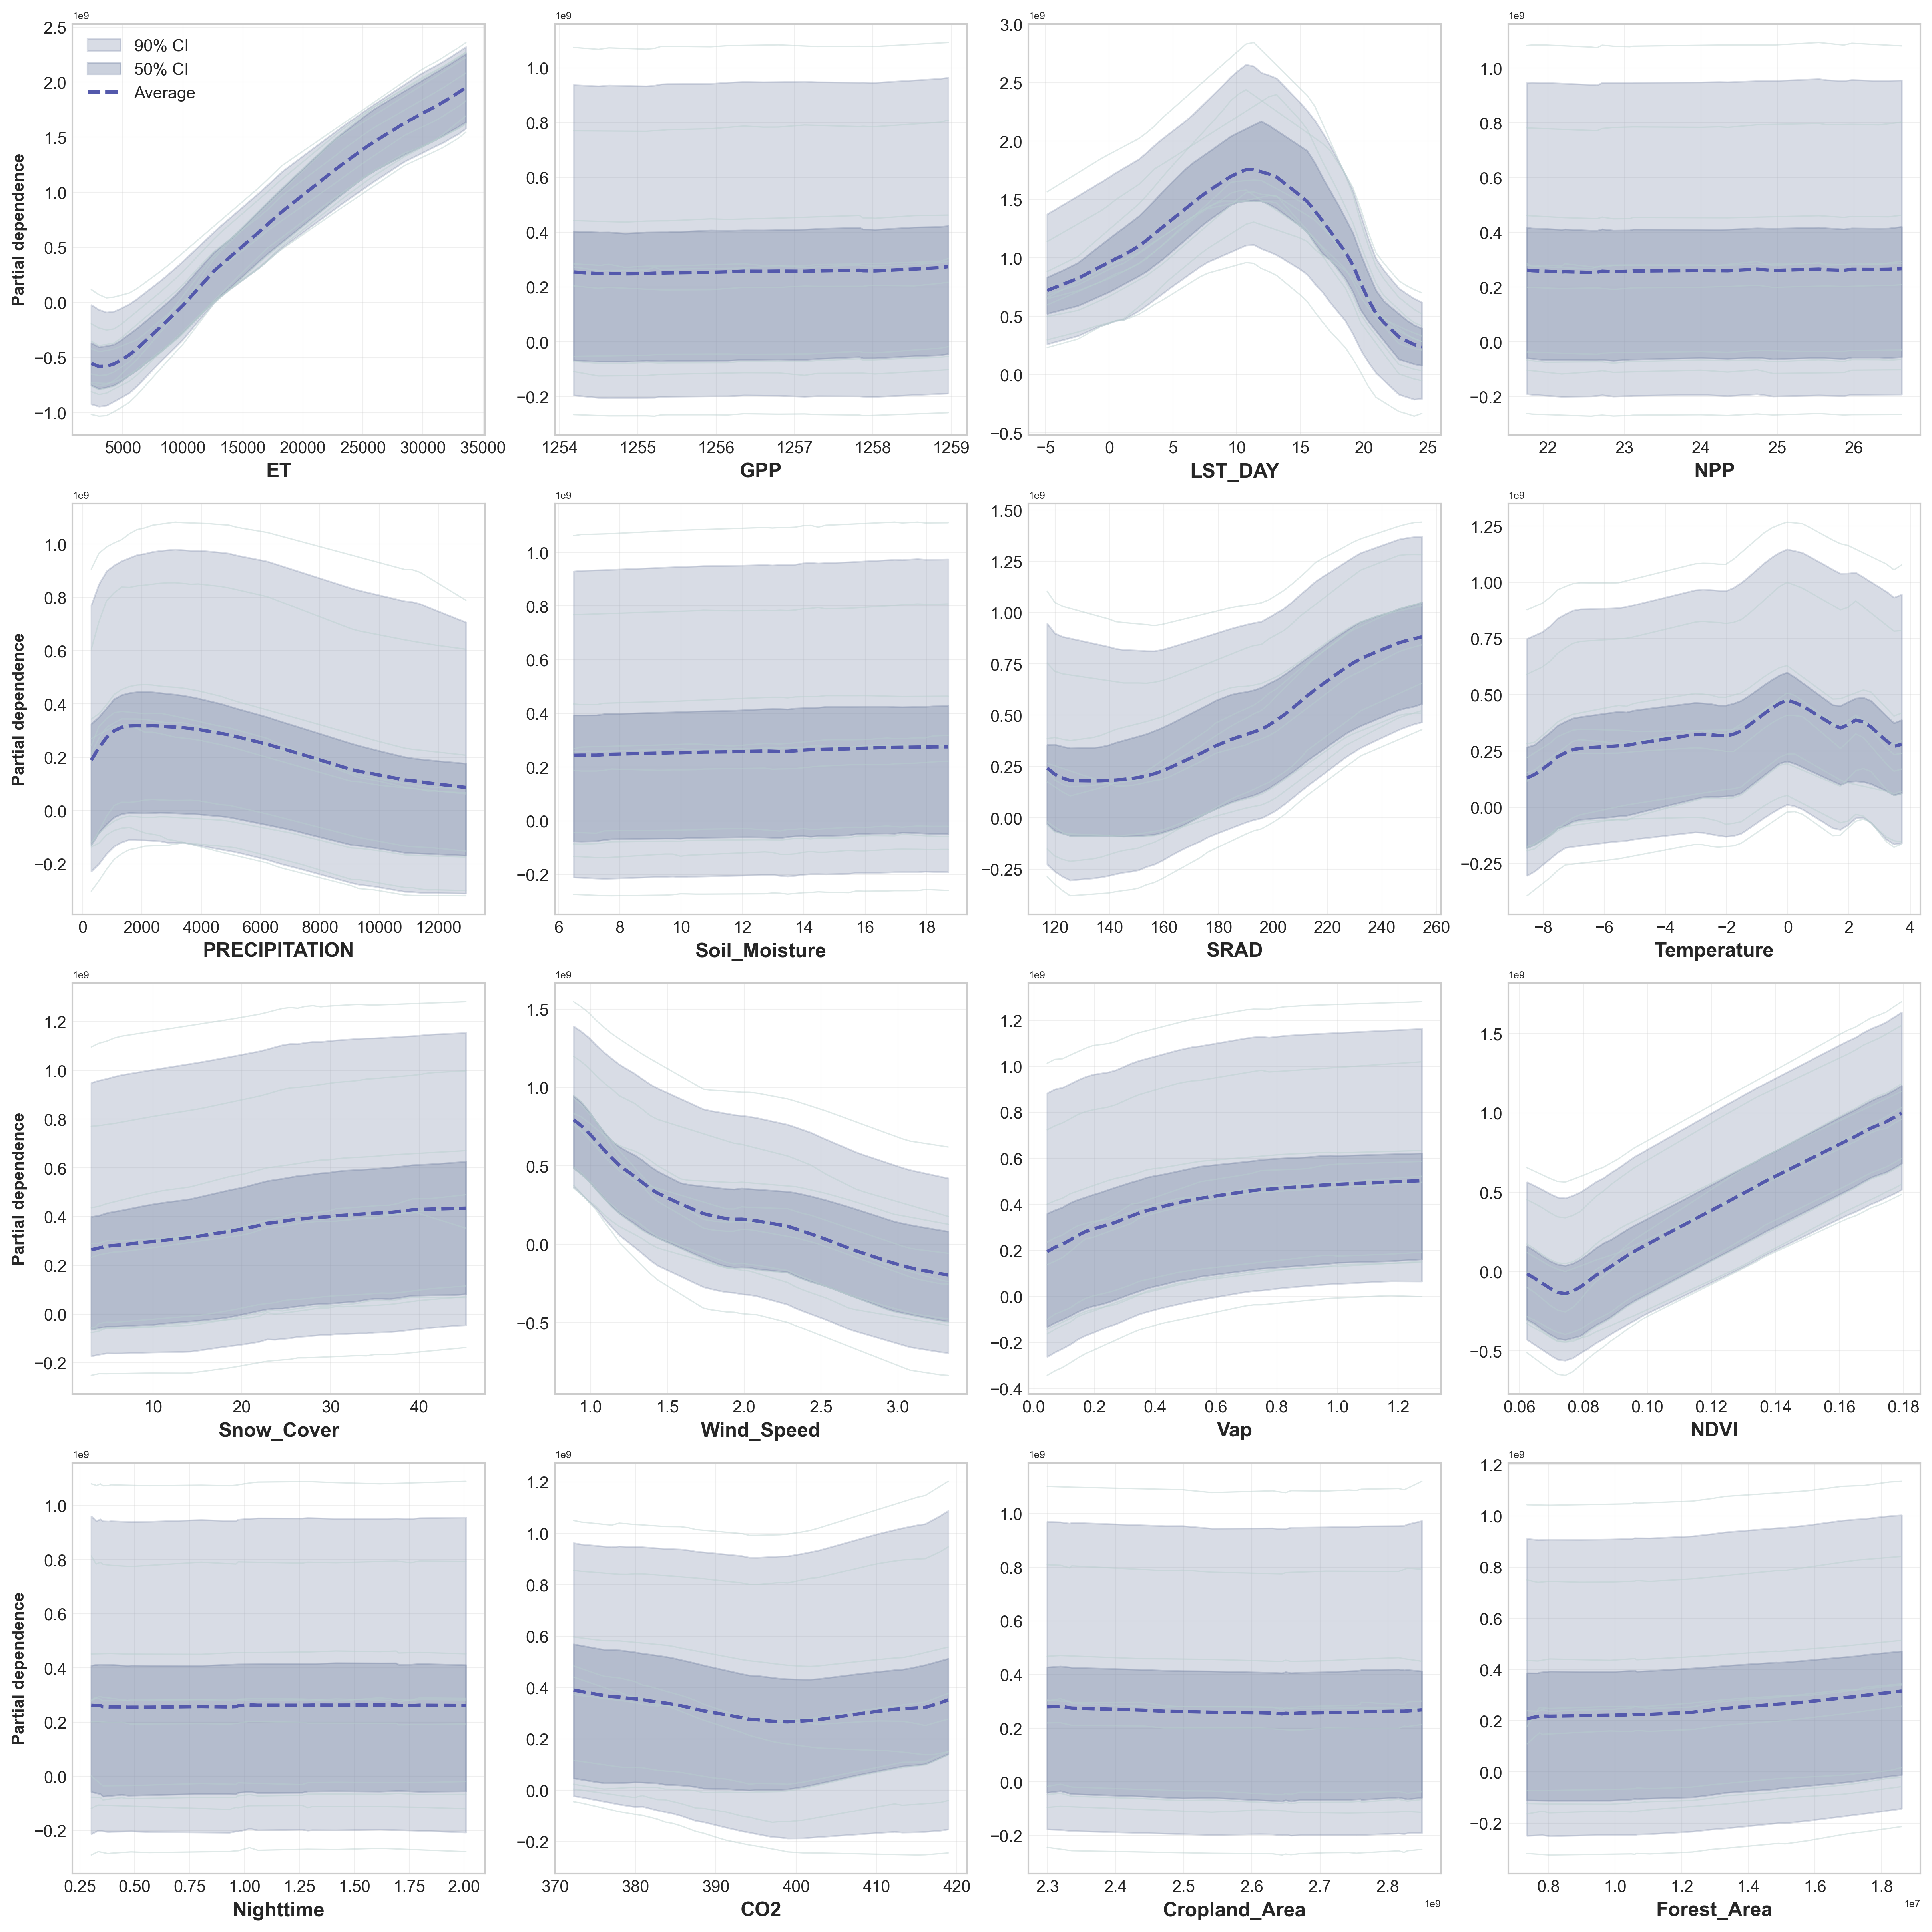

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from matplotlib import font_manager

# 1. 设置Nature风格绘图参数
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 6,
    'axes.titlesize': 8,
    'axes.labelsize': 8,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 6,
    'figure.dpi': 300,
    'grid.alpha': 0.3,
    'lines.linewidth': 1.5,
    'axes.linewidth': 0.8,
    'savefig.bbox': 'tight',
    'savefig.transparent': True
})


def plot_partial_dependence(results, figsize=(16, 16)):
    """
    绘制部分依赖图
    """
    # 创建4x4的子图布局，可以容纳13个变量
    fig, axes = plt.subplots(4, 4, figsize=figsize, constrained_layout=True)
    axes = axes.flatten()
    
    # 设置颜色和样式
    line_color = '#5459AC'  # 红色DA6C6C
    fill_color = '#7F8CAA'  # 浅蓝色
    individual_color = '#B8CFCE'  # 钢蓝色
    
    for i, (feature_name, result) in enumerate(results.items()):
        if i == 16:
            break
        ax = axes[i]
        
        # 获取数据
        feature_values = result['feature_values']
        individual_curves = result['individual_curves']
        main_curve = result['main_curve']
        percentiles = result['percentiles']
        
        # 绘制个体曲线，减少曲线数量
        for curve in individual_curves[:10]:  # 只绘制前10条曲线
            alpha = 0.35 if len(individual_curves) > 20 else 0.45
            ax.plot(feature_values, curve, color=individual_color, 
                   alpha=alpha, linewidth=0.8)
        
        # 绘制置信区间
        ax.fill_between(feature_values, percentiles['5'], percentiles['95'], 
                      color=fill_color, alpha=0.3, label='90% CI')
        ax.fill_between(feature_values, percentiles['25'], percentiles['75'], 
                      color=fill_color, alpha=0.4, label='50% CI')
        
        # 绘制主曲线
        ax.plot(feature_values, main_curve, color=line_color, linestyle='--', 
               linewidth=2.0, label='Average', zorder=10)
        
        # 设置坐标轴标签和格式
        ax.set_xlabel(feature_name, fontsize=12, fontweight='bold')
        if i % 4 == 0:  # 左侧列的子图
            ax.set_ylabel('Partial dependence', fontsize=10, fontweight='bold')
        
        # 添加网格
        ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
        
        # 只在第一个子图添加图例
        if i == 0:
            ax.legend(loc='upper left', fontsize=10, framealpha=0.9)
        
        # 设置刻度标签大小
        ax.tick_params(labelsize=10)
        
        # 设置边框
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(1)
    
    # 隐藏多余的子图
    for i in range(len(results), 16):
        axes[i].set_visible(False)
    
    return fig

def load_results(filename='pd_results.pkl'):
    """
    从文件加载部分依赖结果
    """
    with open(filename, 'rb') as f:
        results = pickle.load(f)
    return results

if __name__ == "__main__":
    # 加载结果
    results = load_results()
    
    # 绘制部分依赖图
    fig = plot_partial_dependence(results)

    plt.show()